In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

import prepare
import prepare_telco

# ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Plan

### Summary

Telco Company's last report reflects a high customer churn rate. This notebook is an evaluation of the main drivers of churn for Telco Co. 

### Goals

- Identify main drivers of churn 
- Create a MVP that accurately predicts a customer's likelihood to churn

# Acquire

In [78]:
import acquire_telco

In [79]:
df = acquire_telco.get_telco_data()


Using cached csv


# Prepare

Prepare.py accomplishes the following: 
- Strips total charges of white space 
- Changes total charges datatype from object to float 
- splits the data: train, validate, test

In [80]:
 df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], inplace=True)

In [81]:
df['total_charges'] = df['total_charges'].str.strip()
df = df[df.total_charges != '']

In [82]:
df['total_charges'] = df.total_charges.astype(float)

In [83]:
df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})

In [84]:
 dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)

In [85]:
df = pd.concat([df, dummy_df], axis=1)

In [86]:
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'internet_service_type', 'contract_type', 'payment_type',
       'gender_encoded', 'partner_encoded', 'dependents_encoded',
       'phone_service_encoded', 'paperless_billing_encoded', 'churn_encoded',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'streaming_movies_Yes',
       'contract_type_

In [87]:
df.drop(columns=['gender', 'senior_citizen', 'partner', 'dependents',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'churn',
       'internet_service_type', 'contract_type', 'payment_type'], inplace=True)

In [88]:
df.head()

,tenure,monthly_charges,total_charges,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_No phone service,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,9,65.6,593.30,1,1,1,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
1,9,59.9,542.40,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,4,73.9,280.85,0,0,0,1,1,1,0,...,0,0,0,0,0,1,0,0,1,0
3,13,98.0,1237.85,0,1,0,1,1,1,0,...,1,0,1,0,0,1,0,0,1,0
4,3,83.9,267.40,1,1,0,1,1,1,0,...,1,0,0,0,0,1,0,0,0,1


### Sort customers into two categories before train/validate split

In [89]:
def bin_tenure(tenure):
    if tenure <= 3: 
        return "brand_new"
    else: 
        return 'not_new'

In [90]:
df["tenure_bin"] = df.tenure.apply(bin_tenure)

In [91]:
new_customers = df[df.tenure_bin == "brand_new"]
old_customers = df[df.tenure_bin == "not_new"]

### New Customers

In [93]:
train_validate, test = train_test_split(new_customers, test_size=.2, random_state=123, stratify=new_customers.churn_encoded)

In [94]:
train, validate = train_test_split(train_validate, test_size=.3, random_state=123, stratify=train_validate.churn_encoded)

In [96]:
X_train_new = train.drop(columns=['churn_encoded'])
y_train_new = train.churn_encoded

X_validate_new = validate.drop(columns=['churn_encoded'])
y_validate_new = validate.churn_encoded

X_test_new = test.drop(columns=['churn_encoded'])
y_test_new = test.churn_encoded

### Old Customers

In [97]:
train_validate, test = train_test_split(old_customers, test_size=.2, random_state=123, stratify=old_customers.churn_encoded)

In [98]:
train, validate = train_test_split(train_validate, test_size=.3, random_state=123, stratify=train_validate.churn_encoded)

In [99]:
X_train_old = train.drop(columns=['churn_encoded'])
y_train_old = train.churn_encoded

X_validate_old = validate.drop(columns=['churn_encoded'])
y_validate_old = validate.churn_encoded

X_test_old = test.drop(columns=['churn_encoded'])
y_test_old = test.churn_encoded

# Explore

### Import original dataframe for exploratory purposes. 

In [26]:
df_explore = acquire_telco.get_telco_data()

Using cached csv


In [27]:
train_validate, test = train_test_split(df_explore, test_size=.2, random_state=123, stratify=df_explore.churn)

In [28]:
train, validate = train_test_split(train_validate, test_size=.3, random_state=123, stratify=train_validate.churn)

How many customers overall churned?

In [208]:
train.churn.value_counts()

No     2897
Yes    1046
Name: churn, dtype: int64

Takeaway: In this dataset 26.5% of customer's churned

For a complete set of visual comparisons of features to churn rate please see original notebook.

### Churn by Feature

Divide tenure: First 90 day customers vs customers over 90 days. 

In [213]:
def bin_tenure(tenure):
    if tenure <= 3: 
        return "brand_new"
    else: 
        return 'not_new'

In [214]:
train["tenure_bin"] = train.tenure.apply(bin_tenure)

In [215]:
new_customers = train[train.tenure_bin == "brand_new"]
old_customers = train[train.tenure_bin == "not_new"]

### What can be learned from customers who churn in their first 90 days? 

<AxesSubplot:xlabel='senior_citizen'>

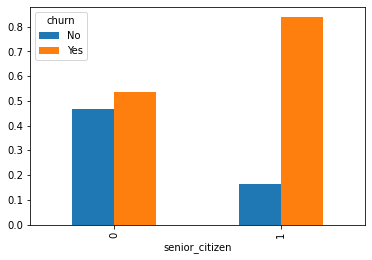

In [216]:
pd.crosstab(new_customers.senior_citizen, new_customers.churn, normalize="index").plot.bar()

Takeaway: Senior citizens churn at a high rate in the first 90 days. Further investigation required.

<AxesSubplot:xlabel='online_security'>

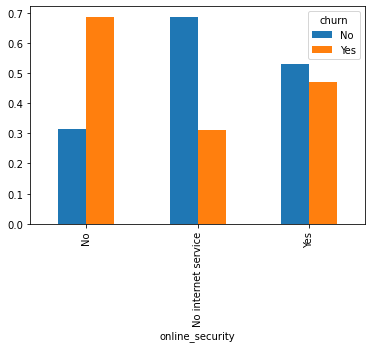

In [219]:
pd.crosstab(new_customers.online_security, new_customers.churn, normalize="index").plot.bar()

Takeaway: Online security churn rate in the first 90 days is similar to overall online security churn rate. No further investigation is required.

<AxesSubplot:xlabel='tech_support'>

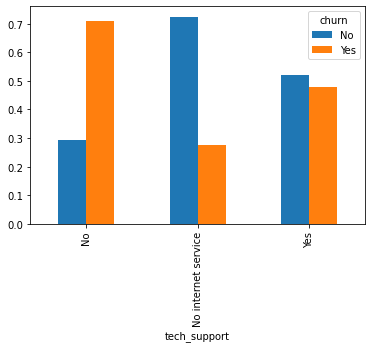

In [31]:
pd.crosstab(new_customers.tech_support, new_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without tech support churn at a higher rate than those with tech support; customers without tech support in the first ninety days churn at a rate nearly twice that of those with tech support. Further investigation is required

### What can be learned about customers who churned after 90 days?

<AxesSubplot:xlabel='senior_citizen'>

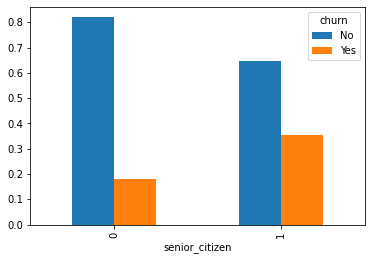

In [33]:
pd.crosstab(old_customers.senior_citizen, old_customers.churn, normalize="index").plot.bar()

Takeaway: Senior citizens still churn at a higher rate than non senior citizens.

<AxesSubplot:xlabel='online_security'>

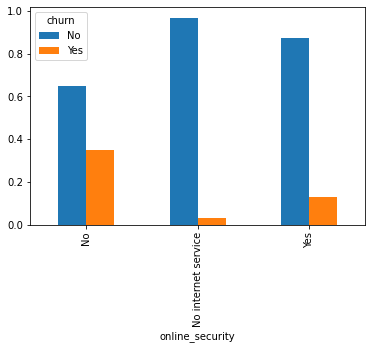

In [36]:
pd.crosstab(old_customers.online_security, old_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without online security churn at a higher rate than customers with online security. Further investigation required. 

<AxesSubplot:xlabel='tech_support'>

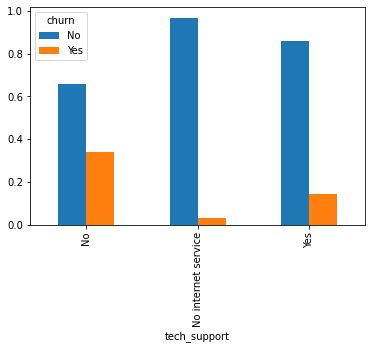

In [39]:
pd.crosstab(old_customers.tech_support, old_customers.churn, normalize="index").plot.bar()

Takeaway: Customers without tech support churn at a higher rate than customers with tech support. Further investigation required.


# Statistical Analysis

### Statistical Analysis will only be performed on features that appear to have a significant relationship with churn: 
- Senior Citizen 
- Online Security 
- Tech Support 
- Online Backup 
- Device Protection



### Chi Square test for overall train set

In [41]:
alpha = 0.05

### Senior Citizen

Initial Hypothesis: 
- H_0: Rate of churn is independent of being a senior citizen. 
- H_a: Rate of churn is not independent of being a senior citizen. 

In [42]:
senior_citizen_customer = pd.crosstab(train.senior_citizen, train.churn)
senior_citizen_customer

churn,No,Yes
senior_citizen,,
0,2527,775
1,364,271


In [43]:
chi2, senior, degf, expected_senior = stats.chi2_contingency(senior_citizen_customer)
print(expected_senior)
print(f"p-val: {senior}")

[[2424.70967742  877.29032258]
 [ 466.29032258  168.70967742]]
p-val: 1.7561315684822695e-23


In [44]:
if senior < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Online Security

Initial Hypothesis: 
- H_0: Rate of churn is independent of having online security. 
- H_a: Rate of churn is not independent of having online security. 

In [45]:
online_security_customer = pd.crosstab(train.online_security, train.churn)
online_security_customer

churn,No,Yes
online_security,,
No,1099,819
No internet service,803,64
Yes,989,163


In [46]:
chi2, online_security, degf, expected_online_security = stats.chi2_contingency(online_security_customer)
print(expected_online_security)
print(f"p-val: {online_security}")

[[1408.41706883  509.58293117]
 [ 636.6515113   230.3484887 ]
 [ 845.93141986  306.06858014]]
p-val: 1.3862996282206897e-111


In [47]:
if online_security < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Tech Support

Initial Hypothesis: 
- H_0: Rate of churn is independent of having tech support. 
- H_a: Rate of churn is not independent of having tech support. 

In [48]:
tech_support_customer = pd.crosstab(train.tech_support, train.churn)
tech_support_customer 

churn,No,Yes
tech_support,,
No,1126,805
No internet service,803,64
Yes,962,177


In [49]:
chi2, tech_support, degf, expected_tech_support = stats.chi2_contingency(tech_support_customer)
print(expected_tech_support)
print(f"p-val: {tech_support}")

[[1417.96316993  513.03683007]
 [ 636.6515113   230.3484887 ]
 [ 836.38531877  302.61468123]]
p-val: 8.373959266633126e-101


In [50]:
if tech_support < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Online Backup 

Initial Hypothesis: 
- H_0: Rate of churn is independent of having online backup. 
- H_a: Rate of churn is not independent of having online backup. 

In [51]:
online_backup_customer = pd.crosstab(train.online_backup, train.churn)
online_backup_customer 

churn,No,Yes
online_backup,,
No,1023,674
No internet service,803,64
Yes,1065,308


In [52]:
chi2, online_backup, degf, expected_online_backup = stats.chi2_contingency(online_backup_customer)
print(expected_online_backup)
print(f"p-val: {online_backup}")

[[1246.13335027  450.86664973]
 [ 636.6515113   230.3484887 ]
 [1008.21513843  364.78486157]]
p-val: 1.6093415124241013e-71


In [53]:
if online_backup < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Device Protection

Initial Hypothesis: 
- H_0: Rate of churn is independent of having device protection. 
- H_a: Rate of churn is not independent of having device protection. 

In [54]:
device_protected_customer = pd.crosstab(train.device_protection, train.churn)
device_protected_customer

churn,No,Yes
device_protection,,
No,1027,666
No internet service,803,64
Yes,1061,316


In [55]:
chi2, device_protection, degf, expected_device_protection = stats.chi2_contingency(device_protected_customer)
print(expected_device_protection)
print(f"p-val: {device_protection}")

[[1243.19608839  449.80391161]
 [ 636.6515113   230.3484887 ]
 [1011.1524003   365.8475997 ]]
p-val: 5.47884290275652e-69


In [56]:
if device_protection < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Tech Support New Customer 

Initial Hypothesis: 
- H_0: Rate of churn for new customers is independent of having tech support. 
- H_a: Rate of churn for new customers is not independent of having tech support. 

In [221]:
tech_support_customer = pd.crosstab(new_customers.tech_support, new_customers.churn)
tech_support_customer 

churn,No,Yes
tech_support,,
No,116,269
No internet service,97,44
Yes,32,20


In [222]:
chi2, tech_support, degf, expected_tech_support = stats.chi2_contingency(tech_support_customer)
print(expected_tech_support)
print(f"p-val: {tech_support}")

[[163.19204152 221.80795848]
 [ 59.76643599  81.23356401]
 [ 22.04152249  29.95847751]]
p-val: 2.6162287495568325e-16


In [223]:
if tech_support < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


### Senior Citizen New Customer

Initial Hypothesis: 
- H_0: Rate of churn for new customers is independent of being a senior citizen. 
- H_a: Rate of churn for new customers is not independent of being a senior citizen. 

In [224]:
senior_citizen_customer = pd.crosstab(new_customers.senior_citizen, new_customers.churn)
senior_citizen_customer

churn,No,Yes
senior_citizen,,
0,232,266
1,13,67


In [225]:
chi2, senior, degf, expected_senior = stats.chi2_contingency(senior_citizen_customer)
print(expected_senior)
print(f"p-val: {senior}")

[[211.0899654 286.9100346]
 [ 33.9100346  46.0899654]]
p-val: 6.533416300990865e-07


In [226]:
if senior < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


Takeaways: 

# Modeling


Baseline Model

Because approximately 27% of customers churn, the baseline model is 1-0.27 = 0.73

# Decision Trees 

### Under 90 day customer

In [100]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [101]:
clf = DecisionTreeClassifier(max_depth=6, random_state=123)

In [102]:

X_train_new = X_train_new.drop(columns=['tenure_bin'])


In [103]:
y_train_new = y_train_new.drop(columns=['tenure_bin'])


In [105]:
clf = clf.fit(X_train_new, y_train_new)

In [107]:
y_pred = clf.predict(X_train_new)
y_pred[0:5]

array([0, 0, 1, 0, 0])

In [108]:
y_pred_proba = clf.predict_proba(X_train_new)
y_pred_proba[0:5]

array([[0.7       , 0.3       ],
       [1.        , 0.        ],
       [0.11111111, 0.88888889],
       [0.5       , 0.5       ],
       [0.62      , 0.38      ]])

In [109]:
print(classification_report(y_train_new, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       254
           1       0.81      0.82      0.82       334

    accuracy                           0.79       588
   macro avg       0.79      0.78      0.78       588
weighted avg       0.79      0.79      0.79       588



In [111]:
X_validate_new = X_validate_new.drop(columns=['tenure_bin'])

In [112]:
y_validate_new = y_validate_new.drop(columns=['tenure_bin'])

In [113]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(clf.score(X_validate_new, y_validate_new)))

Accuracy of random forest classifier on test set: 0.58


### Over 90 day customer

In [114]:
dlf = DecisionTreeClassifier(max_depth=8, random_state=123)

In [115]:
X_train_old = X_train_old.drop(columns=['tenure_bin'])

In [116]:
y_train_old = y_train_old.drop(columns=['tenure_bin'])

In [117]:
dlf = dlf.fit(X_train_old, y_train_old)

In [119]:
y_pred = dlf.predict(X_train_old)
y_pred[0:5]

array([0, 0, 0, 1, 0])

In [120]:
y_pred_proba = dlf.predict_proba(X_train_old)
y_pred_proba[0:5]

array([[0.57142857, 0.42857143],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.45833333, 0.54166667],
       [0.90545455, 0.09454545]])

In [121]:
print(classification_report(y_train_old, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2636
           1       0.71      0.65      0.68       712

    accuracy                           0.87      3348
   macro avg       0.81      0.79      0.80      3348
weighted avg       0.87      0.87      0.87      3348



In [123]:
X_validate_old = X_validate_old.drop(columns=['tenure_bin'])

In [124]:
y_validate_old = y_validate_old.drop(columns=['tenure_bin'])

In [125]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(dlf.score(X_validate_old, y_validate_old)))

Accuracy of random forest classifier on test set: 0.79


### Random Forest

### Under 90 day customer

In [126]:
af = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [127]:
af.fit(X_train_new, y_train_new)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=123)

In [129]:
y_pred = af.predict(X_train_new)

In [130]:
y_pred_proba = af.predict_proba(X_train_new)

In [131]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(af.score(X_train_new, y_train_new)))

Accuracy of random forest classifier on training set: 0.82


In [133]:
print(classification_report(y_train_new, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       254
           1       0.82      0.88      0.85       334

    accuracy                           0.82       588
   macro avg       0.82      0.81      0.82       588
weighted avg       0.82      0.82      0.82       588



In [134]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(af.score(X_validate_new, y_validate_new)))

Accuracy of random forest classifier on test set: 0.64


### New Customer Random Forest Precision: 0.95

In [135]:
X_test_new = X_test_new.drop(columns=['tenure_bin'])

In [136]:
y_test_new = y_test_new.drop(columns=['tenure_bin'])

In [137]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(af.score(X_test_new, y_test_new)))

Accuracy of random forest classifier on test set: 0.72


### Over 90 day customer

In [138]:
gf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [139]:
gf.fit(X_train_old, y_train_old)

RandomForestClassifier(max_depth=10, random_state=123)

In [141]:
y_pred = gf.predict(X_train_old)

In [142]:
y_pred_proba = gf.predict_proba(X_train_old)

In [143]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(gf.score(X_train_old, y_train_old)))

Accuracy of random forest classifier on training set: 0.90


In [145]:
print(classification_report(y_train_old, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2636
           1       0.86      0.63      0.73       712

    accuracy                           0.90      3348
   macro avg       0.88      0.80      0.83      3348
weighted avg       0.90      0.90      0.89      3348



In [146]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(af.score(X_validate_old, y_validate_old)))

Accuracy of random forest classifier on test set: 0.67


### Old Customer Random Forest Precision 0.89

In [147]:
X_test_old = X_test_old.drop(columns=['tenure_bin'])

In [148]:
y_test_old = y_test_old.drop(columns=['tenure_bin'])

In [149]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(af.score(X_test_old, y_test_old)))

Accuracy of random forest classifier on test set: 0.67


# KNN

### Under 90 day customer 

In [150]:
from sklearn.neighbors import KNeighborsClassifier

In [151]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')


In [152]:
knn.fit(X_train_new, y_train_new)

KNeighborsClassifier()

In [153]:
y_pred = knn.predict(X_train_new)

In [154]:
y_pred_proba = knn.predict_proba(X_train_new)

In [155]:
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_train_new, y_train_new)))

Accuracy of KNN classifier on training set: 0.75


In [156]:
print(confusion_matrix(y_train_new, y_pred))

[[174  80]
 [ 66 268]]


In [157]:
print(classification_report(y_train_new, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70       254
           1       0.77      0.80      0.79       334

    accuracy                           0.75       588
   macro avg       0.75      0.74      0.75       588
weighted avg       0.75      0.75      0.75       588



In [158]:
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_validate_new, y_validate_new)))

Accuracy of KNN classifier on training set: 0.60


### New Customer KNN Precison Score: 0.75

### Over 90 day customer 

In [159]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [160]:
knn.fit(X_train_old, y_train_old)

KNeighborsClassifier()

In [161]:
y_pred = knn.predict(X_train_old)

In [162]:
y_pred_proba = knn.predict_proba(X_train_old)

In [163]:
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_train_old, y_train_old)))

Accuracy of KNN classifier on training set: 0.84


In [164]:
print(confusion_matrix(y_train_old, y_pred))

[[2483  153]
 [ 370  342]]


In [165]:
print(classification_report(y_train_old, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2636
           1       0.69      0.48      0.57       712

    accuracy                           0.84      3348
   macro avg       0.78      0.71      0.74      3348
weighted avg       0.83      0.84      0.83      3348



In [166]:
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_validate_old, y_validate_old)))

Accuracy of KNN classifier on training set: 0.78


### Old Customer KNN Precision Score 0.69

# Logistic Regression

### Under 90 day customer

In [167]:
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

In [168]:
logit.fit(X_train_new, y_train_new)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

In [169]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.62363863  0.07163227 -0.0034894   0.07122483 -0.01850217  0.42149535
  -0.18270361  0.81324637  1.95022623  0.29788205  0.07930867 -1.08955555
   0.07930867 -0.41386691  0.07930867  0.01278605  0.07930867 -0.77111451
   0.07930867 -0.04563471  0.07930867 -1.12576139 -0.60748366 -0.12252014
  -0.5759985   0.07930867  0.30847658  0.4709661   0.41221167]]
Intercept: 
 [1.8823469]


In [170]:
y_pred = logit.predict(X_train_new)

In [171]:
y_pred_proba = logit.predict_proba(X_train_new)

In [172]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train_new, y_train_new)))

Accuracy of Logistic Regression classifier on training set: 0.57


In [173]:
print(confusion_matrix(y_train_new, y_pred))

[[  0 254]
 [  0 334]]


In [174]:
print(classification_report(y_train_new, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       254
           1       0.57      1.00      0.72       334

    accuracy                           0.57       588
   macro avg       0.28      0.50      0.36       588
weighted avg       0.32      0.57      0.41       588



### New Customer logistic regression precision score: 0.57

### Over 90 day customer

In [175]:
logit = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

In [176]:
logit.fit(X_train_old, y_train_old)

LogisticRegression(C=1, class_weight={0: 1, 1: 99}, random_state=123)

In [177]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-1.79519849e-02  5.29187945e-02 -7.26466961e-05  1.34441578e-02
   9.88765526e-02 -4.45168208e-01 -1.69476750e-01  2.15746947e-01
   1.11333427e+00 -6.56217175e-02  3.27993351e-02 -2.96952938e-01
   3.27993351e-02 -4.57797493e-01  3.27993351e-02 -3.94313965e-01
   3.27993351e-02 -5.68418930e-01  3.27993351e-02 -3.42314641e-01
   3.27993351e-02  1.18610161e-01 -4.28805973e-01 -1.54684404e+00
  -2.94199695e-01  3.27993351e-02  3.81877193e-01  6.76288472e-01
   1.59683167e-02]]
Intercept: 
 [0.94581485]


In [178]:
y_pred = logit.predict(X_train_old)

In [179]:
y_pred_proba = logit.predict_proba(X_train_old)

In [180]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train_old, y_train_old)))

Accuracy of Logistic Regression classifier on training set: 0.31


In [181]:
print(confusion_matrix(y_train_old, y_pred))

[[ 330 2306]
 [   1  711]]


In [182]:
print(classification_report(y_train_old, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.13      0.22      2636
           1       0.24      1.00      0.38       712

    accuracy                           0.31      3348
   macro avg       0.62      0.56      0.30      3348
weighted avg       0.84      0.31      0.26      3348



### Old Customer logistic regression Precision Score: 0.23

### Under 90 day best classifier: Random Forest 

### Over 90 day best classifier: Random Forest

In [127]:
df = acquire_telco.get_telco_data()

Using cached csv


In [128]:
def bin_tenure(tenure):
    if tenure <= 3: 
        return "brand_new"
    else: 
        return 'not_new'

In [129]:
train["tenure_bin"] = train.tenure.apply(bin_tenure)

In [130]:
new_customers = train[train.tenure_bin == "brand_new"]
old_customers = train[train.tenure_bin == "not_new"]

In [110]:
new_customers['under_90_day_customer_prediction'] = af.predict(X_train_new)

In [123]:
new_customers.to_csv('predictions_new.csv')

In [121]:
old_customers['over_90_day_customer_prediction'] = gf.predict(X_train_old)

In [124]:
old_customers.to_csv('predictions_old.csv')

# Conclusion

This report uses monthly charges, total charges, and tenure as a means of describing a categorical feature: i.e. being a fiber optic customer, senior citizen customer etc. It should be noted that monthly charges, total charges, and tenure are all top drivers of churn. 

### Top factors contributing to churn in the first 90 days: 

Senior Citizens churn at an especially high rate in the first 90 days 

Customers without tech support churn at a higher rate in the first 90 days than customers without tech support after 90 days

### Top factors contributing to churn over 90 days: 

Fiber optic internet customers churn at a much higher rate than DSL customers 

Customers with features like online backup, online security, tech support, and device protection churn at a lower rate than those without

Monthly costs for customers fluctuating from month to month might be a source of dissatisfaction

### If I had additional time I would have liked to: 

1. Fine tune models with use of different hyperparameters

2. Create a function that would produce multiple models 

3. Combine features and/or remove features to improve models